In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import json
torch.manual_seed(1)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#buildig vocab

In [3]:
with open("/content/drive/MyDrive/NLP_ass2/train_processed_t2.json", 'r') as f:
        data = json.load(f)


type(data)

dict

In [4]:
with open("/content/drive/MyDrive/NLP_ass2/validation_processed_t2.json", 'r') as f:
        valid_data = json.load(f)


type(data)

dict

In [5]:
with open("/content/drive/MyDrive/NLP_ass2/test_processed_t2.json", 'r') as f:
        test_data = json.load(f)


type(data)

dict

In [6]:
vocab=[]

for i in data:
  for word in data[str(i)]['text'].split():
    if word not in vocab:
      vocab.append(word)

for i in test_data:
  for word in test_data[str(i)]['text'].split():
    if word not in vocab:
      vocab.append(word)


for i in valid_data:
  for word in valid_data[str(i)]['text'].split():
    if word not in vocab:
      vocab.append(word)


In [7]:
vocab_len=len(vocab)

#model with embedding


In [8]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [9]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,embedding=None):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)


        if embedding is None:
            self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.word_embeds = nn.Embedding.from_pretrained(embedding)
        # self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [10]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 5
HIDDEN_DIM = 4


tag_to_ix = {"B": 0, "I": 1, "O": 2, START_TAG: 3, STOP_TAG: 4}

word_to_ix = {}

for i in data:
  for word in data[str(i)]['text'].split():
    if word not in word_to_ix:
      word_to_ix[word] = len(word_to_ix)

for i in test_data:
  for word in test_data[str(i)]['text'].split():
    if word not in word_to_ix:
      word_to_ix[word] = len(word_to_ix)

for i in valid_data:
  for word in valid_data[str(i)]['text'].split():
    if word not in word_to_ix:
      word_to_ix[word] = len(word_to_ix)

tag_to_ix = {"B": 0, "I": 1, "O": 2, START_TAG: 3, STOP_TAG: 4}




In [11]:
# traning_size=training_data.


def train_model(model,optimizer,traning_data,validation_data,epoch):

  f1score_traning=[]
  f1score_val=[]
  losses=[]
  losses_val=[]
  div=int(len(traning_data)/5)
  arr=[div,div*2,div*3,div*4,div]
  for epoch in range(epoch):
    print("done epoch",epoch)
    last=1
    lossz=0
    for batch in arr:


      for i in range(last,batch):
        last=batch
        ith_data=traning_data[str(i)]

        model.zero_grad()

        # print(ith_data['text'])
        sent_in=torch.tensor([word_to_ix[t] for t in ith_data['text'].split()], dtype=torch.long)


        # print(sent_in)
        targets = torch.tensor([tag_to_ix[t] for t in ith_data['labels']], dtype=torch.long)
        # print(targets)
          # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sent_in, targets)
        lossz+=loss.item()
          # Step 4. Compute the loss, gradients, and update the parameters by
          # calling optimizer.step()
        loss.backward()
        optimizer.step()
    losses.append(lossz)
    f1score_traning.append(test_model(model,traning_data))
    av=0
    for i in validation_data:
        ith_data=validation_data[str(i)]

        model.zero_grad()

        # print(ith_data['text'])
        sent_in=torch.tensor([word_to_ix[t] for t in ith_data['text'].split()], dtype=torch.long)


        # print(sent_in)
        targets = torch.tensor([tag_to_ix[t] for t in ith_data['labels']], dtype=torch.long)
        # print(targets)
          # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sent_in, targets)
        av+=loss.item()
    losses_val.append(av)
    f1score_val.append(test_model(model,validation_data))
  return model,losses,losses_val,f1score_traning,f1score_val








In [12]:
import numpy as np
from sklearn.metrics import f1_score

def test_model(model,testing_data):

  predicted=[]
  orginal=[]

  with torch.no_grad():
    for i in testing_data:

        sent_in=torch.tensor([word_to_ix[t] for t in testing_data[str(i)]['text'].split()], dtype=torch.long)
        targets = [tag_to_ix[t] for t in testing_data[str(i)]['labels']]
        orginal=orginal+targets

        predicted_targer=model(sent_in)
        predicted = predicted +predicted_targer[1]

  score=f1_score(orginal, predicted, average='macro')
  return score

##graphing code

In [39]:
import matplotlib.pyplot as plt

def plotloss(losses,labelt):
  epochs = range(1, len(losses) + 1)

  plt.plot(epochs, losses, marker='o', color='b', linestyle='-')


  plt.xlabel('Epoch Number')
  plt.ylabel(labelt)
  plt.title(f'{labelt} vs. Epoch Number')


  plt.grid(True)
  plt.tight_layout()
  plt.show()




#word to vec encoding


In [14]:
import io

In [ ]:
from gensim.models import KeyedVectors# Load pre-trained model
word2vec_model = KeyedVectors.load_word2vec_format(   '/content/drive/MyDrive/NLP_ass2/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
import numpy as np
wor2vec_dim=len(word2vec_model['hello'])
word2vec_embedd=np.zeros((vocab_len, wor2vec_dim), dtype=np.float32)

t=0
for ind, word in enumerate(vocab):
  try:

    word2vec_embedd[ind,:]=word2vec_model[word]
    t=t+1
  except:
    continue

print(t)
print(vocab_len)
word2vec_embedd = torch.from_numpy(word2vec_embedd)

In [ ]:
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, wor2vec_dim, 256,word2vec_embedd)

optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)




# model,losses,losses_val,f1score_traning,f1score_val
word2vec_traned_model,losses_word2,losses_val,f1score_traning,f1score_val=train_model(model,optimizer,data,valid_data,100)

**traning graph**

In [ ]:
losses_word2
losses_word2

In [ ]:
plotloss(losses_word2)

**traning score**

In [ ]:
score=test_model(word2vec_traned_model,data)
print("F1-score for traning data ",score)

In [ ]:
plotloss(f1score_traning)

**validation**

In [ ]:
plotloss(f1score_val)

**validation graph**

In [ ]:
plotloss(losses_val)

**valid score**

In [ ]:
score=test_model(word2vec_traned_model,valid_data)
print("F1-score for traning data ",score)

**saving model**

In [ ]:
word2vecpath='/content/drive/MyDrive/NLP_ass2/word2vec.pth'
torch.save(word2vec_traned_model.state_dict(), word2vecpath)

**testing score**

In [ ]:
word2vecmidel = torch.load(word2vecpath)

last_model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, wor2vec_dim, 256,word2vec_embedd)
last_model.load_state_dict(word2vecmidel)

score=test_model(last_model,test_data)
print("F1-score for traning data ",score)

#fasttext embedding


In [15]:
fast_embed="/content/drive/MyDrive/NLP_ass2/crawl-300d-2M-subword.vec"

In [16]:
# reference https://github.com/nlptown/nlp-notebooks/blob/master/Sequence%20Labelling%20with%20a%20BiLSTM%20in%20PyTorch.ipynb
fast_vectors={}
i=0
with open(fast_embed) as file:
        for line in file:
          if(i==0):
            i=1
            continue

          vector=line.strip().split()
          x=vector[0]
          if(x in vocab):
            fast_vectors[x]=vector[1:]


In [17]:
import numpy as np
fasttext_dim=len(fast_vectors['.'])
fasttext_embedd=np.zeros((vocab_len, fasttext_dim), dtype=np.float32)

t=0
for ind, word in enumerate(vocab):
  try:
    fasttext_embedd[ind,:]=fast_vectors[word]
    t=t+1
  except:
    continue

print(t)
print(vocab_len)
fasttext_embedd = torch.from_numpy(fasttext_embedd)

3420
3495


In [18]:
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, fasttext_dim, 256,fasttext_embedd)

optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)





fasttext_traned_model,losses_fasttext,losses_val,f1score_traning,f1score_val=train_model(model,optimizer,data,valid_data,100)

done epoch 0
done epoch 1
done epoch 2
done epoch 3
done epoch 4
done epoch 5
done epoch 6
done epoch 7
done epoch 8
done epoch 9
done epoch 10
done epoch 11
done epoch 12
done epoch 13
done epoch 14
done epoch 15
done epoch 16
done epoch 17
done epoch 18
done epoch 19
done epoch 20
done epoch 21
done epoch 22
done epoch 23
done epoch 24
done epoch 25
done epoch 26
done epoch 27
done epoch 28
done epoch 29
done epoch 30
done epoch 31
done epoch 32
done epoch 33
done epoch 34
done epoch 35
done epoch 36
done epoch 37
done epoch 38
done epoch 39
done epoch 40
done epoch 41
done epoch 42
done epoch 43
done epoch 44
done epoch 45
done epoch 46
done epoch 47
done epoch 48
done epoch 49
done epoch 50
done epoch 51
done epoch 52
done epoch 53
done epoch 54
done epoch 55
done epoch 56
done epoch 57
done epoch 58
done epoch 59
done epoch 60
done epoch 61
done epoch 62
done epoch 63
done epoch 64
done epoch 65
done epoch 66
done epoch 67
done epoch 68
done epoch 69
done epoch 70
done epoch 71
do

**Traning graph**

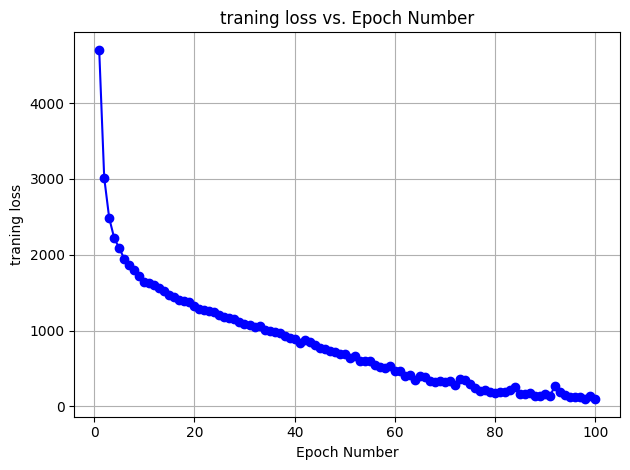

In [40]:
plotloss(losses_fasttext,"traning loss")

**Traning score**

In [20]:

score=test_model(fasttext_traned_model,data)
print("F1-score for traning data ",score)

F1-score for traning data  0.9285034007136458


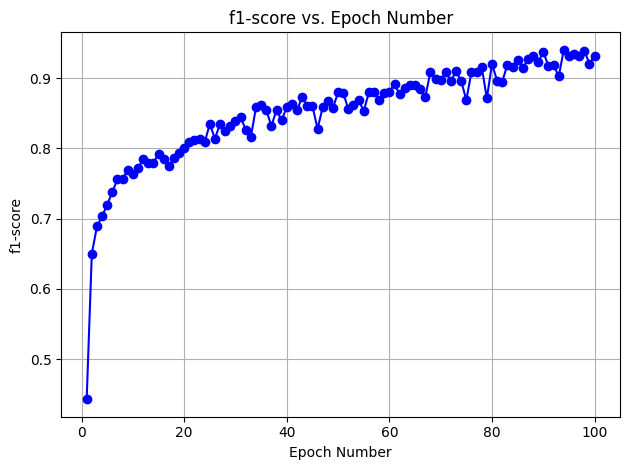

In [41]:
plotloss(f1score_traning,"f1-score")

**validation**

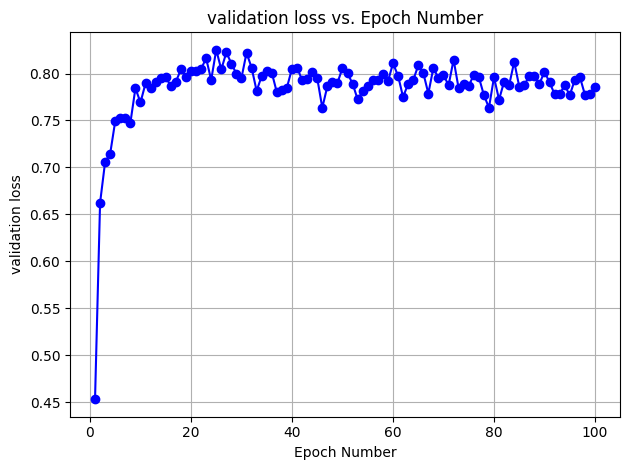

In [42]:
plotloss(f1score_val,"validation loss")

**validation graph**

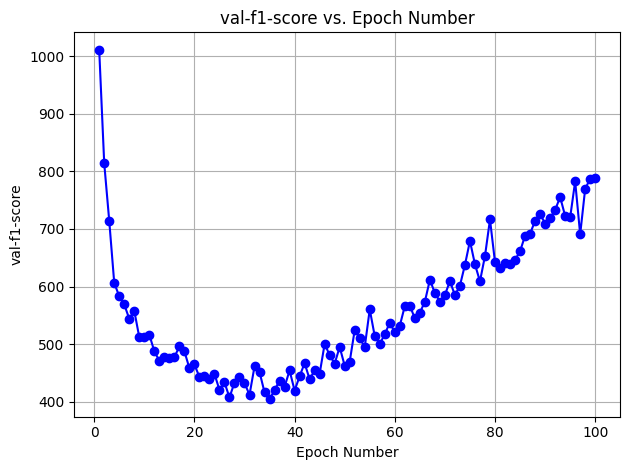

In [43]:
plotloss(losses_val,"val-f1-score")

**validation score**

In [24]:
score=test_model(fasttext_traned_model,valid_data)
print("F1-score for traning data ",score)

F1-score for traning data  0.7825672908752342


**save model**

In [25]:
fasttextpath='/content/drive/MyDrive/NLP_ass2/fasttext.pth'
torch.save(fasttext_traned_model.state_dict(), fasttextpath)

**Testing score**

In [26]:
fasttextmidel = torch.load(fasttextpath)

last_model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, fasttext_dim, 256,fasttext_embedd)
last_model.load_state_dict(fasttextmidel)

score=test_model(last_model,test_data)
print("F1-score for traning data ",score)

F1-score for traning data  0.8032702843359497


#glove

In [27]:
glove_embed="/content/drive/MyDrive/NLP_ass2/crawl-300d-2M-subword.vec"

In [28]:
glove_vectors={}
i=0
with open(glove_embed) as file:
        for line in file:
          if(i==0):
            i=1
            continue

          vector=line.strip().split()
          x=vector[0]
          if(x in vocab):
            glove_vectors[x]=vector[1:]

In [29]:
import numpy as np
glove_dim=len(glove_vectors['.'])
glove_embedd=np.zeros((vocab_len, glove_dim), dtype=np.float32)

t=0
for ind, word in enumerate(vocab):
  try:
    glove_embedd[ind,:]=glove_vectors[word]
    t=t+1
  except:
    continue

print(t)
print(vocab_len)
glove_embedd = torch.from_numpy(glove_embedd)

3420
3495


In [30]:
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, glove_dim, 256,glove_embedd)

optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)





glove_traned_model,losses_glove,losses_val,f1score_traning,f1score_val=train_model(model,optimizer,data,valid_data,100)

done epoch 0
done epoch 1
done epoch 2
done epoch 3
done epoch 4
done epoch 5
done epoch 6
done epoch 7
done epoch 8
done epoch 9
done epoch 10
done epoch 11
done epoch 12
done epoch 13
done epoch 14
done epoch 15
done epoch 16
done epoch 17
done epoch 18
done epoch 19
done epoch 20
done epoch 21
done epoch 22
done epoch 23
done epoch 24
done epoch 25
done epoch 26
done epoch 27
done epoch 28
done epoch 29
done epoch 30
done epoch 31
done epoch 32
done epoch 33
done epoch 34
done epoch 35
done epoch 36
done epoch 37
done epoch 38
done epoch 39
done epoch 40
done epoch 41
done epoch 42
done epoch 43
done epoch 44
done epoch 45
done epoch 46
done epoch 47
done epoch 48
done epoch 49
done epoch 50
done epoch 51
done epoch 52
done epoch 53
done epoch 54
done epoch 55
done epoch 56
done epoch 57
done epoch 58
done epoch 59
done epoch 60
done epoch 61
done epoch 62
done epoch 63
done epoch 64
done epoch 65
done epoch 66
done epoch 67
done epoch 68
done epoch 69
done epoch 70
done epoch 71
do

**traning graph**

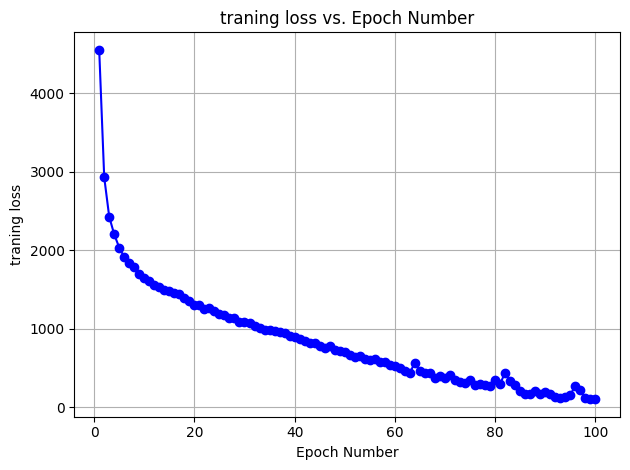

In [44]:
plotloss(losses_glove,"traning loss")

**traning score**

In [32]:
score=test_model(glove_traned_model,data)
print("F1-score for traning data ",score)

F1-score for traning data  0.9266666263235727


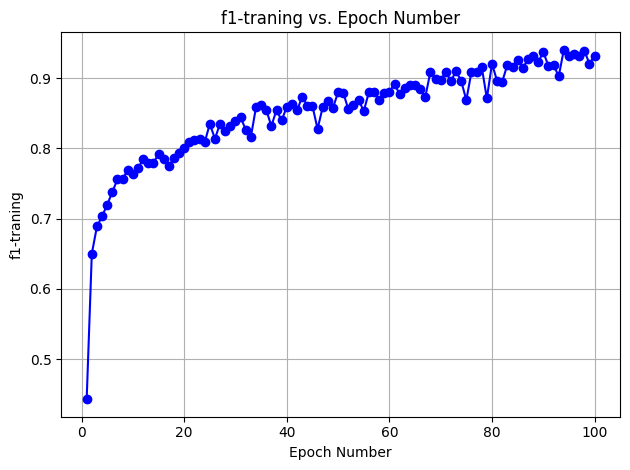

In [45]:

plotloss(f1score_traning,"f1-traning")

**validation**

**validation graph**

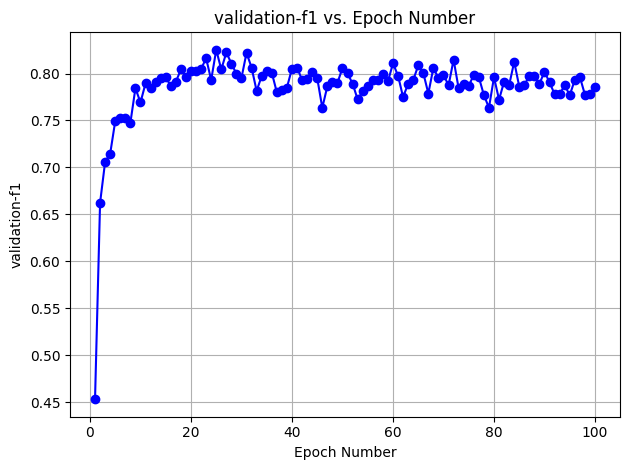

In [46]:
plotloss(f1score_val,"validation-f1")

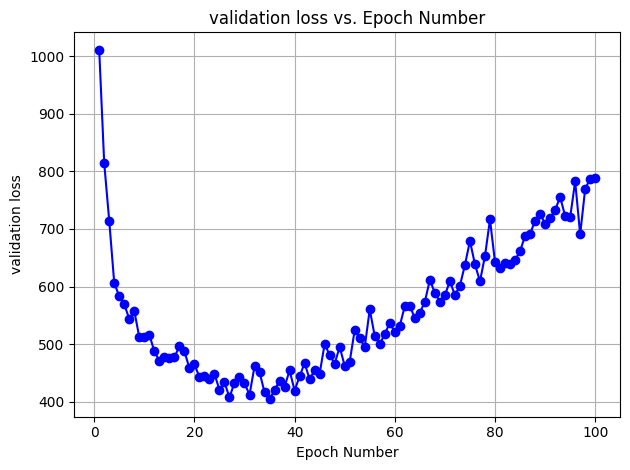

In [47]:
plotloss(losses_val,"validation loss")

**validation score**

In [36]:
score=test_model(glove_traned_model,valid_data)
print("F1-score for traning data ",score)

F1-score for traning data  0.7999264251793461


**model saving**

In [37]:
glovepath='/content/drive/MyDrive/NLP_ass2/glovepath.pth'
torch.save(glove_traned_model.state_dict(), glovepath)

**testing score**

In [38]:
glovevmodel = torch.load(glovepath)

last_model =  BiLSTM_CRF(len(word_to_ix), tag_to_ix, glove_dim, 256,glove_embedd)
last_model.load_state_dict(glovevmodel)

score=test_model(last_model,test_data)
print("F1-score for traning data ",score)

F1-score for traning data  0.8079759051222668
